<a href="https://colab.research.google.com/github/Abderrahmane-Br/Hybrid-model-for-time-series-forecasting/blob/CNN-LSTM/cnn-lstm-var1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [179]:
# elect_data = pd.read_csv("/content/BrentSpotPrice.csv", index_col="Date")
# elect_data = pd.read_csv("/content/AirPassengers.csv", index_col="Month")
# elect_data = pd.read_csv("/content/Electric_Production.csv", index_col="DATE")
elect_data = pd.read_csv("/content/MedicineData.csv", index_col="date")
# elect_data = pd.read_csv("/content/S&P500.csv", index_col="Date")
# elect_data = pd.read_csv("/content/YearlySunspots.csv", usecols=["time", "value"], index_col="time", parse_dates=True)
# elect_data = pd.read_csv("/content/covid_day_wise.csv", usecols=["Date", "New deaths"], index_col="Date")
# elect_data = pd.read_csv("/content/PDB_Load_History.csv", usecols=["date", "demand"], index_col="date")
# elect_data = pd.read_csv("/content/daily-total-female-births-CA.csv", index_col="date")
# elect_data.index = pd.to_datetime(elect_data.index)


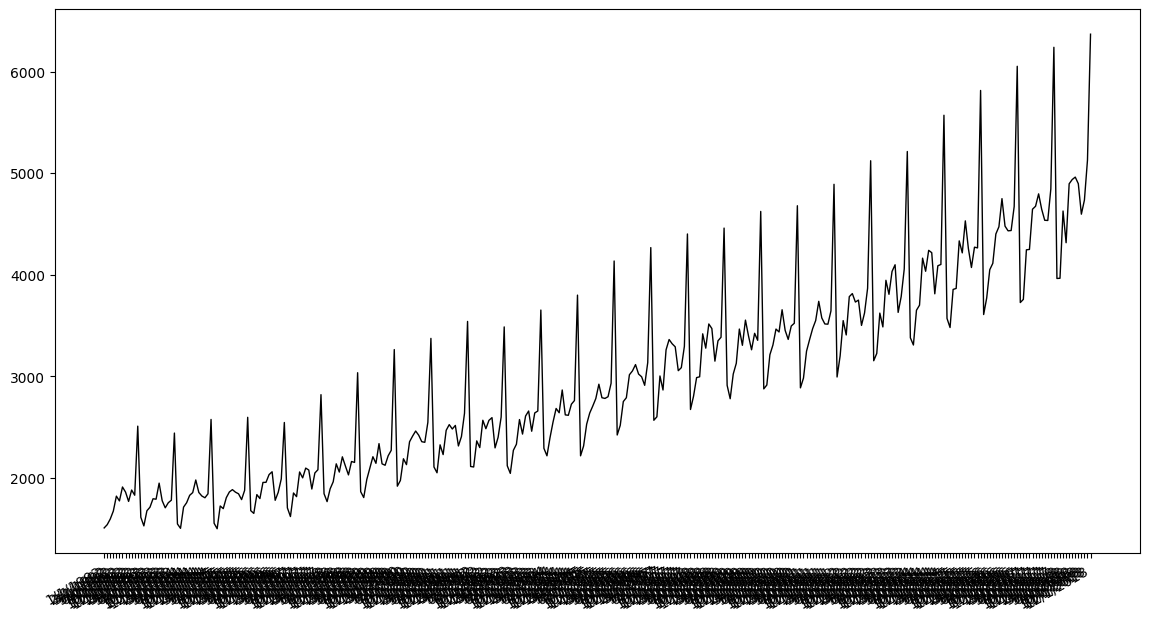

In [180]:
import matplotlib.dates as mdates
plt.rcParams["figure.figsize"] = [14, 8]
loc = mdates.MonthLocator(4)
min_loc = mdates.MonthLocator()
fig, ax = plt.subplots()
# ax.xaxis.set_major_locator(loc)
# ax.xaxis.set_minor_locator(min_loc)
ax.tick_params(colors="black")
plt.xticks(rotation=45)
fig.autofmt_xdate()

ax.plot(elect_data,'-', color="black", linewidth=1)
# plt.savefig('../test1.png', dpi=300)

In [181]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(elect_data)
train_scaled = scaler.transform(elect_data)
split_point = int(len(train_scaled) * 0.7)
# inputs = torch.tensor(elect_data["Brent Spot Price"], dtype=torch.float32)
train_set = torch.tensor(train_scaled[:split_point], dtype=torch.float32)
test_set = torch.tensor(train_scaled[split_point:], dtype=torch.float32)

In [182]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, kernel_size, output_size=1):
        super().__init__()

        self.hidden_size = hidden_size
        self.output_size = output_size

        self.conv = nn.Conv1d(1, 1, kernel_size)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, input):
        conv_out = self.conv(input.permute(1, 0)).squeeze(0)
        lstm_out, (hidden, cell) = self.lstm(conv_out.view(len(conv_out), 1))
        out = self.linear(lstm_out[-self.output_size:])
        
        return out

In [183]:
def slide(model, optimizer, sequence, lookback, horizon): 

  seq_len = len(sequence)
  results = [None] * (seq_len - lookback)
  for i in range(0, seq_len - lookback - horizon + 1):
    out = model(sequence[i:i+lookback])
    # print(out)
    loss = loss_fun(out, sequence[i+lookback: i+lookback+horizon])
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    temp = out.detach().flatten().tolist()
    results[i: i+horizon] = [*temp]


  return results


In [185]:
lookback = 20
horizon = 8
model = LSTM(1, 25, 2, 1, horizon)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)
loss_fun = nn.MSELoss()
epochs = 250

In [186]:
results = []
for epoch in range(epochs): 
  # results = slide(model, optimizer, torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,11, 12, 13, 14, 15], dtype=torch.float32), 4, 2)
  results = slide(model, optimizer, train_set, lookback, horizon)
# print(list(map(lambda x: np.array(x), results)))
# results = [el for res in results for el in res
# print(len(results))

tensor(0.0333)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([206, 1])) that is different to the input size (torch.Size([206])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


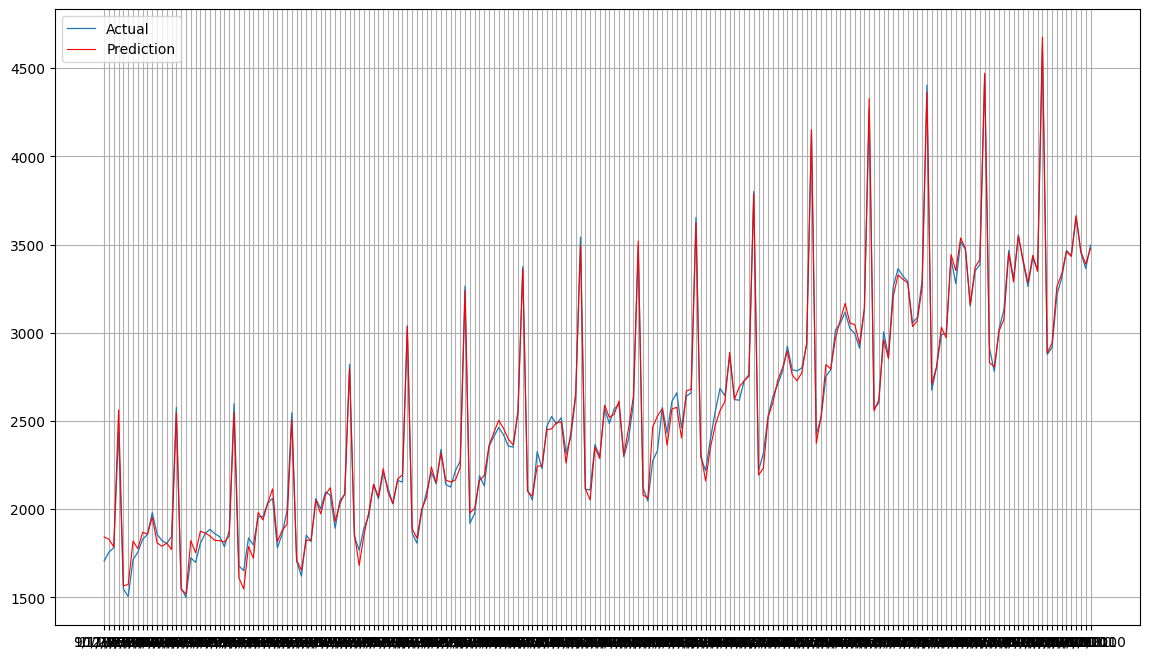

In [187]:
print(loss_fun(torch.tensor(results),train_set[lookback:]))
# print(len(elect_data.index[lookback:split_point]))
scaled_res = scaler.inverse_transform(np.array(results).reshape(-1, 1))
# print(scaled_res)
# print(np.array(results).reshape(-1, 1))
plt.plot(elect_data[lookback:split_point], linewidth=0.9)
results_df = pd.DataFrame(data = scaled_res, index=elect_data.index[lookback:split_point])
# # print(results_df)
plt.grid(True)
plt.plot(results_df, color="red", linewidth=0.8)
plt.legend(["Actual", "Prediction"])

In [188]:
slide_test_set = torch.cat((train_set[-lookback:], test_set))
slide_test_out = slide(model, optimizer, slide_test_set, lookback, horizon)

tensor(0.0399)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([98, 1])) that is different to the input size (torch.Size([98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Text(0.5, 1.0, 'Model: LB=20, hor=8, lr=0.001, lstm=(h=25, 1), kernel=2, trLoss=0.0333, tstLoss=0.0399, data=Medicine')

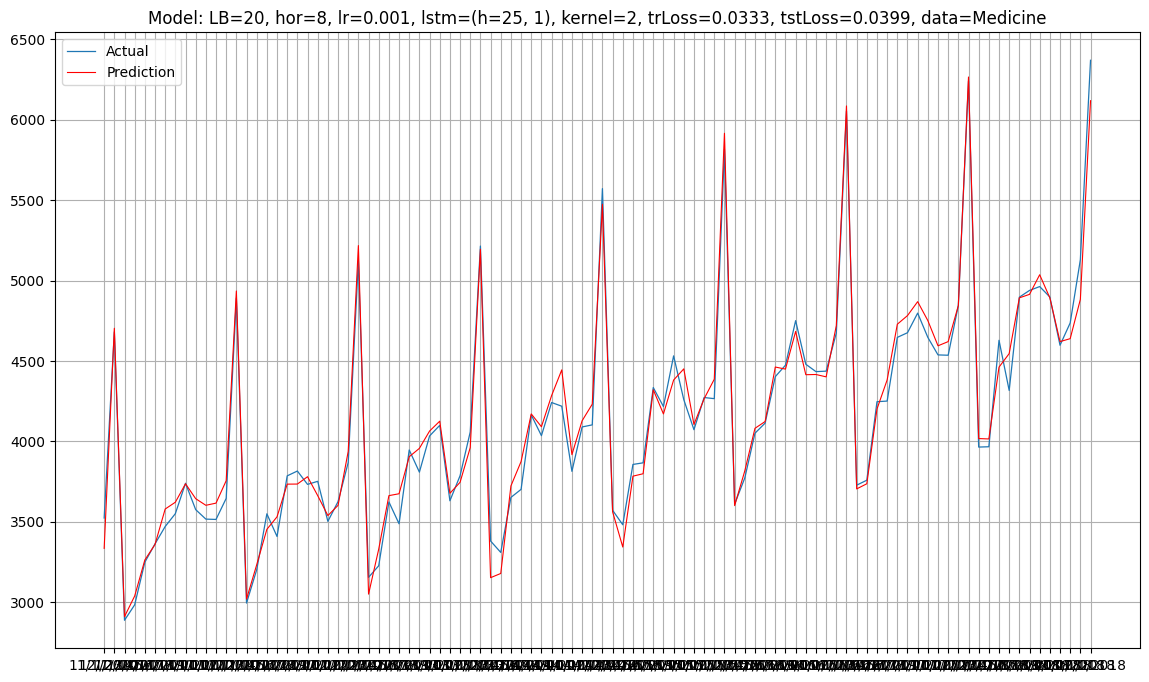

In [201]:
print(loss_fun(torch.tensor(slide_test_out), test_set))
scaled_res = scaler.inverse_transform(np.array(slide_test_out).reshape(-1, 1))
plt.plot(elect_data[split_point:], linewidth=0.9)
results_df = pd.DataFrame(data = scaled_res, index=elect_data.index[split_point:])
plt.grid(True)
plt.plot(results_df, color="red", linewidth=0.8)
plt.legend(["Actual", "Prediction"])
plt.title('Model: LB=20, hor=8, lr=0.001, lstm=(h=25, 1), kernel=2, trLoss=0.0333, tstLoss=0.0399, data=Medicine')


In [190]:
con = nn.Conv1d(1, 1, 3)
tn = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,11, 12, 13, 14, 15], dtype=torch.float32)
out = con(tn.unsqueeze(0))
print(out.squeeze(0))

tensor([0.6862, 0.8052, 0.9241, 1.0430, 1.1619, 1.2809, 1.3998, 1.5187, 1.6377,
        1.7566, 1.8755, 1.9944, 2.1134, 1.6188, 1.8382, 1.8755, 1.9944, 2.1134],
       grad_fn=<SqueezeBackward1>)


In [191]:
lstm = nn.LSTM(1, 5, 1)
tn = torch.tensor([1, 2, 3, 4, 5, 6], dtype=torch.float32)
out, _ = lstm(tn.view(6, 1))
print(out)

lin = nn.Linear(5, 1)
print(lin(out))


tensor([[ 0.0106,  0.1485, -0.0751, -0.0955, -0.1130],
        [ 0.0517,  0.3012, -0.2726, -0.2361, -0.1331],
        [ 0.0832,  0.4164, -0.4681, -0.3587, -0.1287],
        [ 0.0982,  0.4965, -0.5947, -0.4412, -0.1170],
        [ 0.1024,  0.5557, -0.6669, -0.4876, -0.1048],
        [ 0.0998,  0.6024, -0.7091, -0.5056, -0.0947]],
       grad_fn=<SqueezeBackward1>)
tensor([[ 0.1964],
        [ 0.0386],
        [-0.0897],
        [-0.1704],
        [-0.2193],
        [-0.2512]], grad_fn=<AddmmBackward0>)


In [192]:
print(con(train_set[:5].permute(1, 0)))
# print(train_set[:5].squeeze(-1))

tensor([[0.3443, 0.3461, 0.3497]], grad_fn=<SqueezeBackward1>)


In [193]:
ls = scaler.inverse_transform(loss_fun(torch.tensor(slide_test_out).flatten(), torch.clone(test_set).squeeze(-1)).reshape(-1, 1))
print(ls)

[[1502.83933402]]
